In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
pd.set_option('display.max_columns', None)
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#Importing the data
final_df=pd.DataFrame()
a_df=pd.DataFrame()
b_df=pd.DataFrame()
c_df=pd.DataFrame()

for file_n in os.listdir('listings'):
    if file_n[0]=='.':
        continue
    else:
        add_df = pd.read_csv(f'listings/{file_n}')
        if len(add_df.columns)==106:
            final_df = pd.concat([final_df, add_df], axis=0)
        elif len(add_df.columns)==96:
            a_df = pd.concat([a_df, add_df], axis=0)
        elif len(add_df.columns)==95:
            b_df = pd.concat([b_df, add_df], axis=0)
        else:
            c_df = pd.concat([c_df, add_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## Combining all 52 datasets, removing columns not present in all

In [3]:
#These are the columns not present in 2018 reports. They will be dropped.
not_in_2018 = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
       'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'number_of_reviews_ltm', 
       'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
       'calculated_host_listings_count_shared_rooms']
sf_df = final_df.drop(columns=not_in_2018)
sf_df = pd.concat([sf_df, a_df], axis=0)

#drop one column not in 2017
sf_df = sf_df.drop(columns=['is_business_travel_ready'])
sf_df = pd.concat([sf_df, b_df], axis=0)

#drop 3 columns not in 2016 & Prior
sf_df = sf_df.drop(columns=['access', 'interaction', 'house_rules'])
sf_df = pd.concat([sf_df, c_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


## Data Cleaning

In [4]:
pd.set_option('display.max_rows', 20)
#Converting Existing Data Columns to Dates
sf_df['last_scraped'] = pd.to_datetime(sf_df['last_scraped'])
sf_df['host_since'] = pd.to_datetime(sf_df['host_since'])
#Adding new date features
sf_df['year'] = sf_df['last_scraped'].transform(lambda x: x.year)
sf_df['month-year'] = sf_df['last_scraped'].transform(lambda x: f'{x.month} {x.year}')
sf_df['month'] = sf_df['last_scraped'].transform(lambda x: x.month)
sf_df['day_of_week'] = sf_df['last_scraped'].transform(lambda x: x.dt.dayofweek)
sf_df['day'] = sf_df['last_scraped'].transform(lambda x: x.day)

#Converting All Price Related Columns from Objects to Floats
sf_df['price'] = sf_df['price'].transform(lambda x: float(x.replace(',', '').replace('$', '')))
sf_df['extra_people'] = sf_df['extra_people'].transform(lambda x: float(x.replace(',', '').replace('$', '')))

#Fill NaNs in fee columns with 0's, because no additional fee, then convert
sf_df[['security_deposit','cleaning_fee']] = sf_df[['security_deposit','cleaning_fee']].fillna(int(0))
sf_df['security_deposit'] = sf_df['security_deposit'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))
sf_df['cleaning_fee'] = sf_df['cleaning_fee'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))

#Dropping columns that have over 75% null
over_70_null = sf_df.columns[sf_df.isnull().sum()/len(sf_df) > 0.70]
sf_df = sf_df.drop(columns=over_70_null)

#Removing Outliers (0 & over 2000 daily rate)
outlier_thresh=2000
sf_df = sf_df.loc[~((sf_df['price'] == 0) | (sf_df['price'] > outlier_thresh))]

#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (sf_df['room_type']=='Entire home/apt')
sf_df.loc[cond1 & (sf_df['beds']==0), sf_df.columns=='beds'] = 1
sf_df.loc[cond1 & (sf_df['bathrooms']==0), sf_df.columns=='bathrooms'] = 1
#For the rest, just fill na
sf_df[['beds','bathrooms', 'bedrooms']] = sf_df[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    sf_df[review] = sf_df[review].fillna(sf_df[review].mean())

## Train Test Split #1: Use 2015 - 2018 to predict 2019 & 2020

In [5]:
test_years=[2020,2019]
train_df = sf_df[~sf_df['year'].isin(test_years)]
test_df = sf_df[sf_df['year'].isin(test_years)]

## Dumb Model: Predicting the average list price for all

In [6]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
Xd = train_df[features]
yd = train_df['price']
X_train, X_val, y_train, y_val = train_test_split(Xd, yd, test_size=0.3)

In [7]:
average = np.mean(y_train)
preds_d = np.full(y_val.shape, average)
rmse = np.sqrt(mean_squared_error(preds_d, y_val))
rmse

209.59653472415002

## Baseline Models: No Parameter Tuning or Feature Engineering

In [8]:
baseline_rmse = []
baseline_r2 = []
baseline_rmse2 = []
baseline_r22 = []

In [9]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
X = train_df[features]
y = train_df['price'].apply(np.log)

In [10]:
X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [12]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                            0
neighbourhood_cleansed_Haight Ashbury    0
neighbourhood_cleansed_Inner Sunset      0
neighbourhood_cleansed_Lakeshore         0
neighbourhood_cleansed_Marina            0
                                        ..
property_type_Loft                       0
property_type_Other                      0
property_type_Pension (Korea)            0
property_type_Plane                      0
accommodates                             0
Length: 122, dtype: int64

In [13]:
estimator = LinearRegression()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X, y, cv=3)
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6189949061153379, RMSE: 1.5301879664104654,
Cross Val Scores: [0.585767   0.59947152 0.6177368 ]


In [14]:
estimator = DecisionTreeRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X, y, cv=3)
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.8223123650810067, RMSE: 1.3371002924233342,
Cross Val Scores: [0.58859154 0.82052083 0.72889827]


In [15]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X, y, cv=3)
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8807295046085588, RMSE: 1.2687175596817892,
Cross Val Scores: [0.73708189 0.87798245 0.8230411 ]


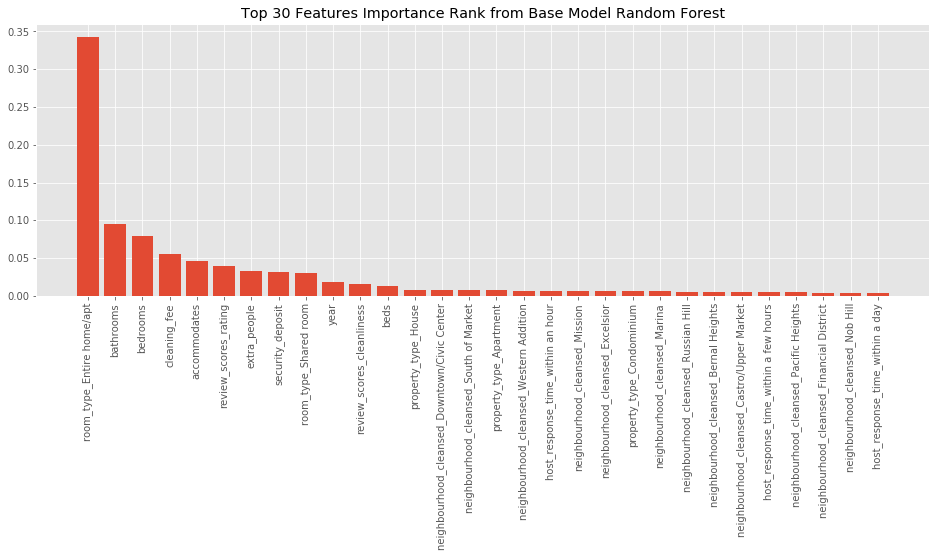

In [16]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)

In [17]:
estimator = GradientBoostingRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X, y, cv=3)
baseline_rmse.append(rmse)
baseline_r2.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6611576733545789, RMSE: 1.4935613010988222,
Cross Val Scores: [0.63551178 0.63906002 0.66177769]


## Train Test Split Option 2: Randomized test group

In [18]:
train_df2, test = train_test_split(sf_df, test_size = 0.3, random_state=0)

## Test Dumb Model First

In [19]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
Xd = train_df2[features]
yd = train_df2['price']
X_train, X_val, y_train, y_val = train_test_split(Xd, yd, test_size=0.3)
average = np.mean(y_train)
preds_d = np.full(y_val.shape, average)
rmse = np.exp(np.sqrt(mean_squared_error(preds_d, y_val)))
rmse

2.2640319395224426e+88

In [20]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 'year']
Xa = train_df2[features]
ya = train_df2['price'].apply(np.log)

Xa = pd.get_dummies(Xa, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(Xa, ya, test_size=0.3)

In [21]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                       0
neighbourhood_cleansed_Presidio     0
neighbourhood_cleansed_Lakeshore    0
neighbourhood_cleansed_Marina       0
neighbourhood_cleansed_Mission      0
                                   ..
property_type_Lighthouse            0
property_type_Loft                  0
property_type_Other                 0
property_type_Pension (Korea)       0
accommodates                        0
Length: 126, dtype: int64

In [22]:
estimator = LinearRegression()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, Xa, ya, cv=3)
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6145349065099552, RMSE: 1.5367535101500305,
Cross Val Scores: [0.61206165 0.61949503 0.61294271]


In [23]:
estimator = DecisionTreeRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, Xa, ya, cv=3)
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.8262380198688946, RMSE: 1.3344032245907698,
Cross Val Scores: [0.81687436 0.8258727  0.8176995 ]


In [24]:
estimator = RandomForestRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, Xa, ya, cv=3)
baseline_rmse2.append(rmse)
baseline_r22.append(np.mean(cs_val))
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8863752210977928, RMSE: 1.2627374552149582,
Cross Val Score: 0.8824320967194345


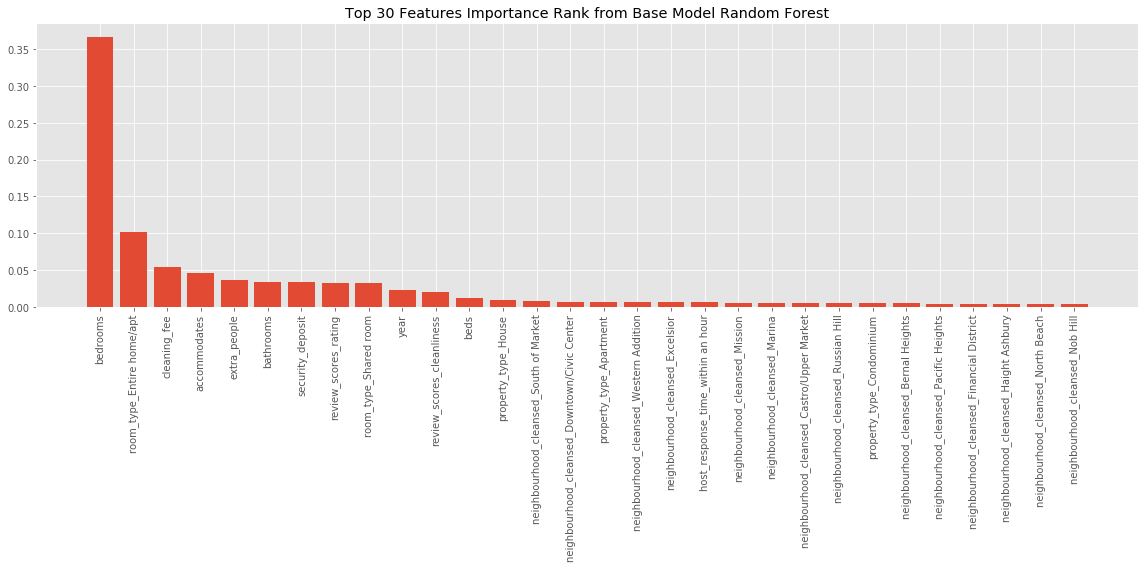

In [25]:
rf_features = X_train.columns
rf_feature_imp = modela.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)
plt.show()

In [26]:
estimator = GradientBoostingRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, Xa, ya, cv=3)
baseline_rmse2.append(rmse)
baseline_r22.append(cs_val)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val)}')

R2: 0.6499584351766066, RMSE: 1.5059942896586944,
Cross Val Score: 0.650318968266265


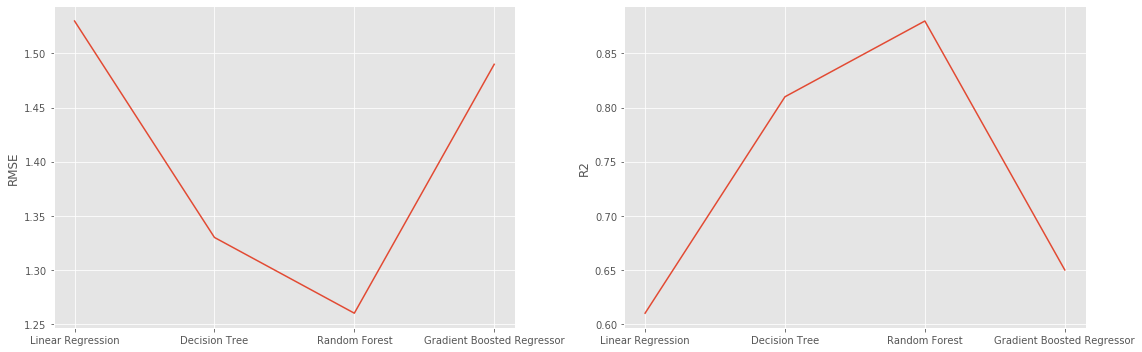

In [27]:
baseline_rmses=[1.53,1.33,1.26,1.49]
baseline_r2=[0.61,0.81,0.88,0.65]

x = np.arange(len(baseline_r22))
x_lab = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Regressor']
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(x_lab, baseline_rmses)
ax[0].set_xticks(x_lab)
ax[0].set_ylabel('RMSE')
ax[1].plot(x_lab, baseline_r2)
ax[1].set_xticks(x_lab)
ax[1].set_ylabel('R2')
plt.tight_layout()
# plt.savefig('Graphs/Baseline_Models.png', dpi=300)

## Model Metrics Tracking

In [28]:
train_rmses = []
train_r2s = []
crossval_r2 = []
val_rmses = []
val_r2s = []

## Model Iteration #1: Fee columns (Y or N) with random split

In [29]:
cols = ['has_deposit','has_cleaning_fee','extra_people_fee']

train_df2['has_deposit'] = train_df2['security_deposit'].transform(lambda x: 1 if x>0 else 0)
train_df2['has_cleaning_fee'] = train_df2['cleaning_fee'].transform(lambda x: 1 if x>0 else 0)
train_df2['extra_people_fee'] = train_df2['extra_people'].transform(lambda x: 1 if x>0 else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

In [30]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 'year',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X1 = train_df2[features]
y1 = train_df2['price'].apply(np.log)

X1 = pd.get_dummies(X1, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3)

In [31]:
estimator = RandomForestRegressor()
model1 = estimator.fit(X_train,y_train)
train_preds = model1.predict(X_train)
train_r2 = model1.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model1.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model1.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X1, y1, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.885202262252528, Val RMSE: 1.2631750694444333,
 Validation Cross Val Score: 0.8820019428115833


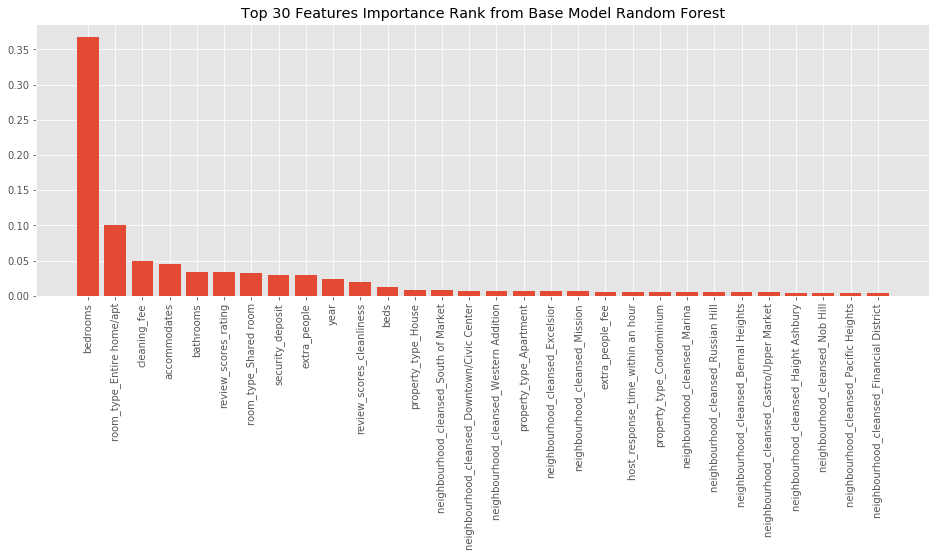

In [32]:
rf_features = X_train.columns
rf_feature_imp = model1.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

In [33]:
#Keep only Y or N column, remove the previous columns
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'month','day_of_week', 'year',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X1a = train_df2[features]
y1a = train_df2['price'].apply(np.log)

X1a = pd.get_dummies(X1a, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X1a, y1a, test_size=0.3)

In [34]:
estimator = RandomForestRegressor()
model1a = estimator.fit(X_train,y_train)
train_preds = model1a.predict(X_train)
train_r2 = model1a.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model1a.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model1a.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X1a, y1a, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.8451275401003211, Val RMSE: 1.3121248784608512,
 Validation Cross Val Score: 0.8428389009718519


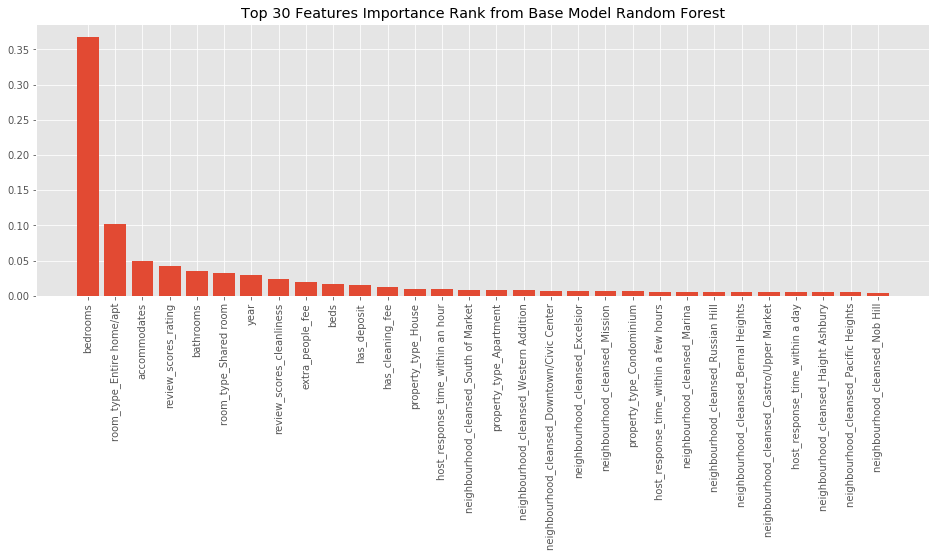

In [35]:
rf_features = X_train.columns
rf_feature_imp = model1a.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

## Model Iteration 2: Count of Amenities, random test/train/split

In [36]:
train_df2['amenities'] = train_df2['amenities'].fillna('0')
train_df2['num_amenities'] = train_df2['amenities'].transform(lambda x: len(x.split(',')))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X2 = train_df2[features]
y2 = train_df2['price'].apply(np.log)

X2 = pd.get_dummies(X2, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.3)

In [38]:
estimator = RandomForestRegressor()
model2 = estimator.fit(X_train,y_train)
train_preds = model2.predict(X_train)
train_r2 = model2.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model2.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model2.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X2, y2, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9086616818789984, Val RMSE: 1.2328023756109172,
 Validation Cross Val Score: 0.9079448350239661


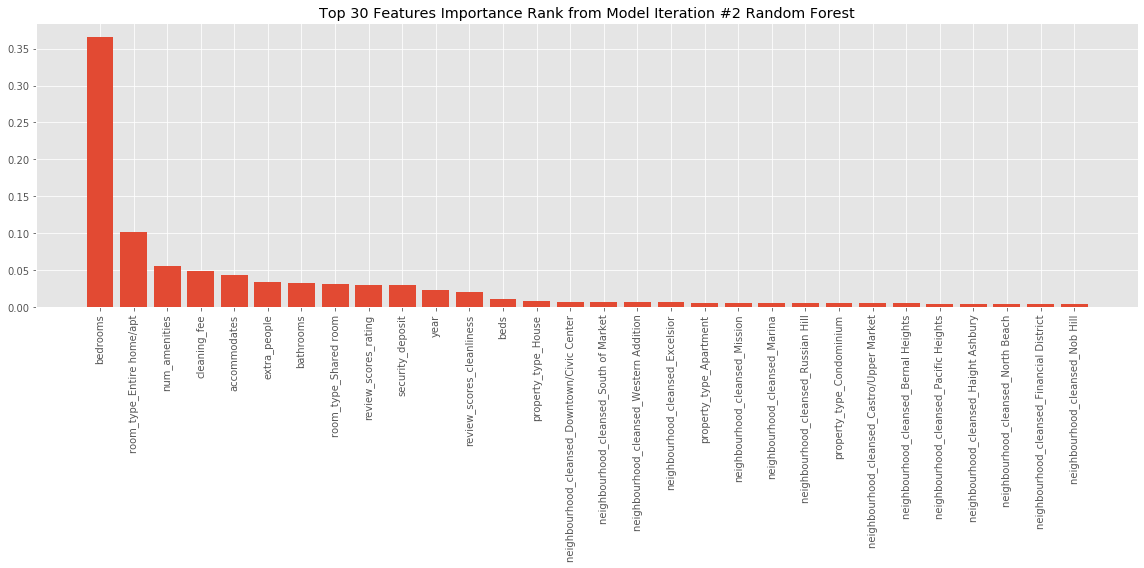

In [39]:
rf_features = X_train.columns
rf_feature_imp = model2.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/num_amenities_imp.png', dpi=300)
plt.show()

## Model Iteration 3: Indicate when property is over a threshold in terms of accommodation features (accomodates, #bedrooms, #bathrooms, #beds)

In [40]:
accom_thresh = 12
bedroom_thresh = 6
bathroom_thresh = 6 #or could be 3?
beds_thresh = 9
train_df2['over_accm'] = train_df2['accommodates'].transform(lambda x: 1 if x>accom_thresh else 0)
train_df2['over_bdrm'] = train_df2['bedrooms'].transform(lambda x: 1 if x>bedroom_thresh else 0)
train_df2['over_btrm'] = train_df2['bathrooms'].transform(lambda x: 1 if x>bathroom_thresh else 0)
train_df2['over_beds'] = train_df2['beds'].transform(lambda x: 1 if x>beds_thresh else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [41]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities', 'over_accm','over_bdrm','over_btrm', 'over_beds',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X3 = train_df2[features]
y3 = train_df2['price'].apply(np.log)

X3 = pd.get_dummies(X3, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X3, y3, test_size=0.3)

In [42]:
estimator = RandomForestRegressor()
model3 = estimator.fit(X_train,y_train)
train_preds = model3.predict(X_train)
train_r2 = model3.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model3.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model3.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X3, y3, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9094468937659494, Val RMSE: 1.2317609796295095,
 Validation Cross Val Score: 0.9082605477741467


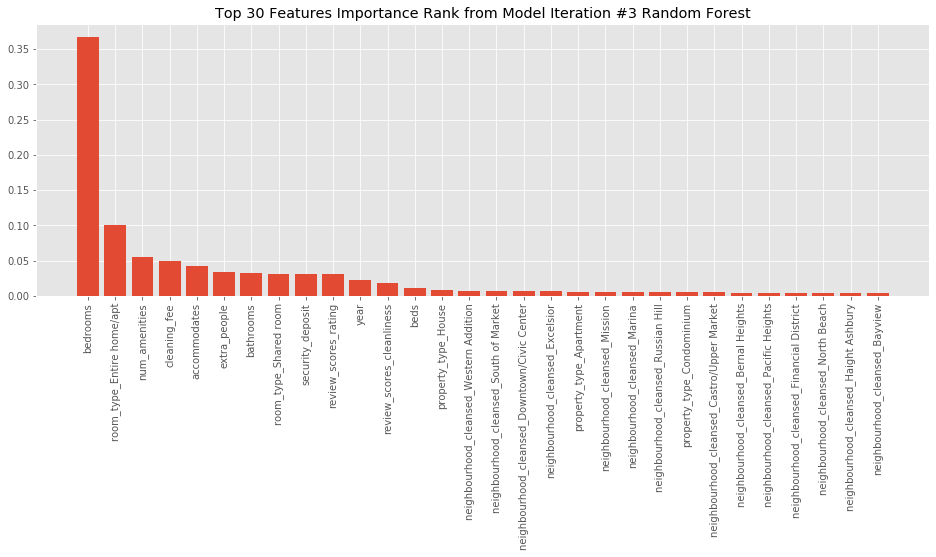

In [43]:
rf_features = X_train.columns
rf_feature_imp = model3.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #3 Random Forest')
plt.show()

## Model Iteration 4: Regions

In [44]:
Northeast = ["Mission", "Western Addition", "South Of Market", "Castro/Upper Market,"
             "Downtown/Civic Center", "Haight Ashbury", "Nob Hill", "Marina", "Pacific Heights",
            "Russian Hill", "North Beach", "Financial District", "Chinatown", "Presidio Heights"]
Southeast = ["Bernal Heights", "Noe Valley", "Potrero Hill", "Excelsior", "Bayview", "Glen Park", 
             "Visitacion Valley," "Crocker Amazon", "Diamond Heights"]
Northwest = ["Inner Richmond", "Outer Sunset", "Outer Richmond", "Inner Sunset", "Twin Peaks", 
             "Seacliff", "Golden Gate Park", "Presidio"]
Southwest = ["Outer Mission", "Parkside", "West of Twin Peaks", "Ocean View", "Lakeshore"]
Other = ["Treasure Island/YBI"]

def region(x):
    if x in Northeast:
        return 'Northeast'
    elif x in Southeast:
        return 'Southeast'
    elif x in Northwest:
        return "Northwest"
    elif x in Southwest:
        return "Southwest"
    else:
        return "Other"
train_df2['Region'] = train_df2['neighbourhood_cleansed'].apply(region)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities',
         'Region','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X4 = train_df2[features]
y4 = train_df2['price'].apply(np.log)

X4 = pd.get_dummies(X4, columns=['bed_type','Region','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X4, y4, test_size=0.3)

In [46]:
estimator = RandomForestRegressor()
model4 = estimator.fit(X_train,y_train)
train_preds = model4.predict(X_train)
train_r2 = model4.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model4.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model4.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X4, y4, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.8918075299621898, Val RMSE: 1.2557255227052628,
 Validation Cross Val Score: 0.8893478418925772


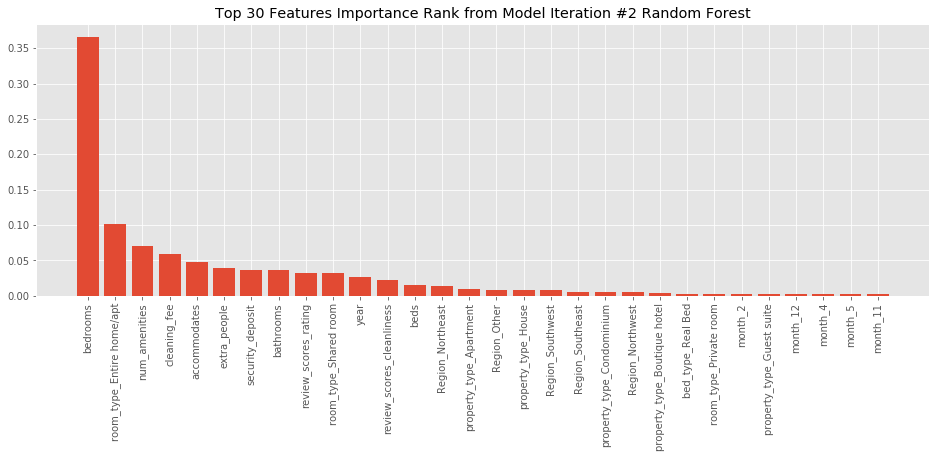

In [47]:
rf_features = X_train.columns
rf_feature_imp = model4.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 5: Downtown or not

In [48]:
downtown = ["Western Addition", "South Of Market", "Downtown/Civic Center", 
                    "Financial District"]
train_df2['Downtown'] = train_df2['neighbourhood_cleansed'].transform(lambda x: 1 if x in downtown else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year',
         'Downtown']
X5 = train_df2[features]
y5 = train_df2['price'].apply(np.log)

X5 = pd.get_dummies(X5, columns=['bed_type','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X5, y5, test_size=0.3)

In [50]:
estimator = RandomForestRegressor()
model5 = estimator.fit(X_train,y_train)
train_preds = model5.predict(X_train)
train_r2 = model5.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model5.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model5.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X5, y5, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.8796017591551676, Val RMSE: 1.2710637893079695,
 Validation Cross Val Score: 0.8744635917234209


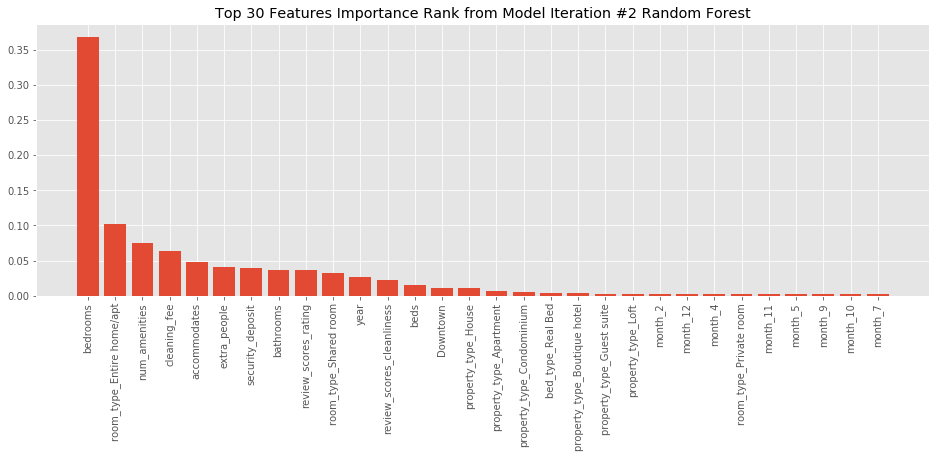

In [51]:
rf_features = X_train.columns
rf_feature_imp = model5.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 6: Apartment or Shared Room, Property Type: House Only

In [52]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X6 = train_df2[features]
y6 = train_df2['price'].apply(np.log)

X6 = pd.get_dummies(X6, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

In [53]:
X6 = X6.drop(columns=['room_type_Hotel room', 'room_type_Private room'])

In [54]:
X6.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'extra_people', 'num_amenities', 'review_scores_cleanliness',
       'review_scores_rating', 'security_deposit',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=114)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X6, y6, test_size=0.3)

In [56]:
estimator = RandomForestRegressor()
model6 = estimator.fit(X_train,y_train)
train_preds = model6.predict(X_train)
train_r2 = model6.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model6.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model6.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X6, y6, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.91165290619859, Val RMSE: 1.227215793586507,
 Validation Cross Val Score: 0.9079350660788673


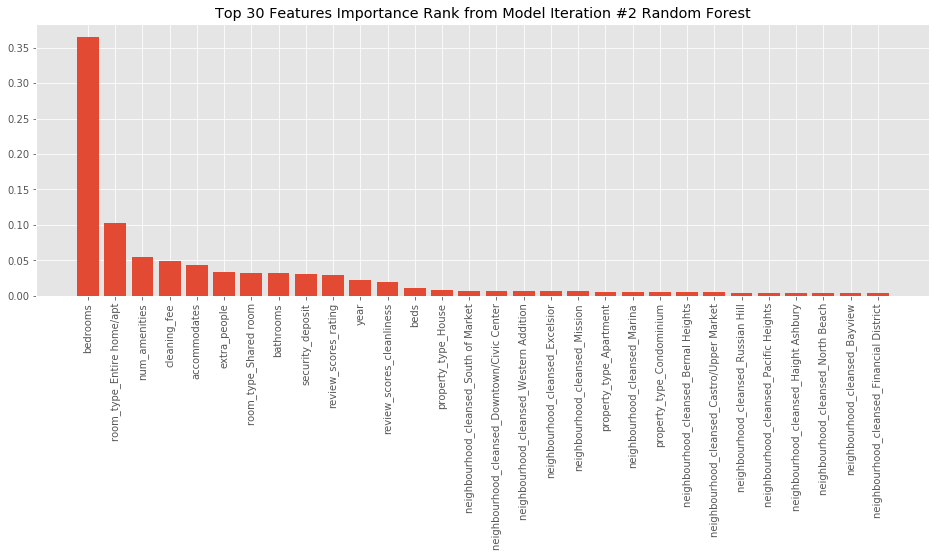

In [57]:
rf_features = X_train.columns
rf_feature_imp = model6.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

In [58]:
#Remove all property types but house
X6a = X6.drop(columns=['property_type_Aparthotel',
       'property_type_Barn', 'property_type_Bed & Breakfast',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin', 'property_type_Camper/RV',
       'property_type_Casa particular', 'property_type_Castle',
       'property_type_Cave', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Cycladic house (Greece)', 'property_type_Dome house',
       'property_type_Dorm', 'property_type_Earth House',
       'property_type_Earth house', 'property_type_Entire Floor', 'property_type_Floor',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_Hotel',
       'property_type_Hut', 'property_type_In-law', 'property_type_Island',
       'property_type_Lighthouse', 'property_type_Loft', 'property_type_Other',
       'property_type_Pension (Korea)', 
       'property_type_Resort', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Timeshare',
       'property_type_Tiny house', 'property_type_Yurt',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Vacation home', 'property_type_Villa','property_type_Tipi'])
not_in_axis = ['property_type_Farm stay', 'property_type_Plane',]

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X6a, y6, test_size=0.3)

In [60]:
estimator = RandomForestRegressor()
model6a = estimator.fit(X_train,y_train)
train_preds = model6a.predict(X_train)
train_r2 = model6a.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model6a.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model6a.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X6a, y6, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9073598830944168, Val RMSE: 1.2345151856863084,
 Validation Cross Val Score: 0.905910796207707


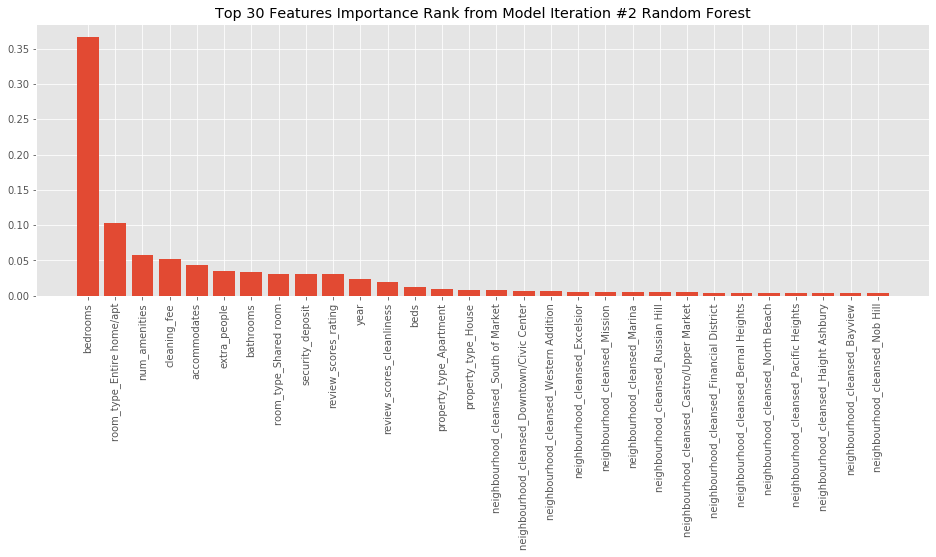

In [61]:
rf_features = X_train.columns
rf_feature_imp = model6a.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 7: Adding Text Lengths

In [62]:
train_df2[['space','summary','description','name']] = train_df2[['space','summary','description','name']].fillna('0')
train_df2['len_space'] = train_df2['space'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_summary'] = train_df2['summary'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_description'] = train_df2['description'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_name'] = train_df2['name'].transform(lambda x: 0 if x=='0' else len(x))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [63]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'room_type', 'security_deposit', 'month', 
          'year']
X7 = train_df2[features]
y7 = train_df2['price'].apply(np.log)

X7 = pd.get_dummies(X7, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X7, y7, test_size=0.3)

In [65]:
estimator = RandomForestRegressor()
model7 = estimator.fit(X_train,y_train)
train_preds = model7.predict(X_train)
train_r2 = model7.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model7.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model7.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X7, y7, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9328949025985331, Val RMSE: 1.1957403476814847,
 Validation Cross Val Score: 0.928563979555734


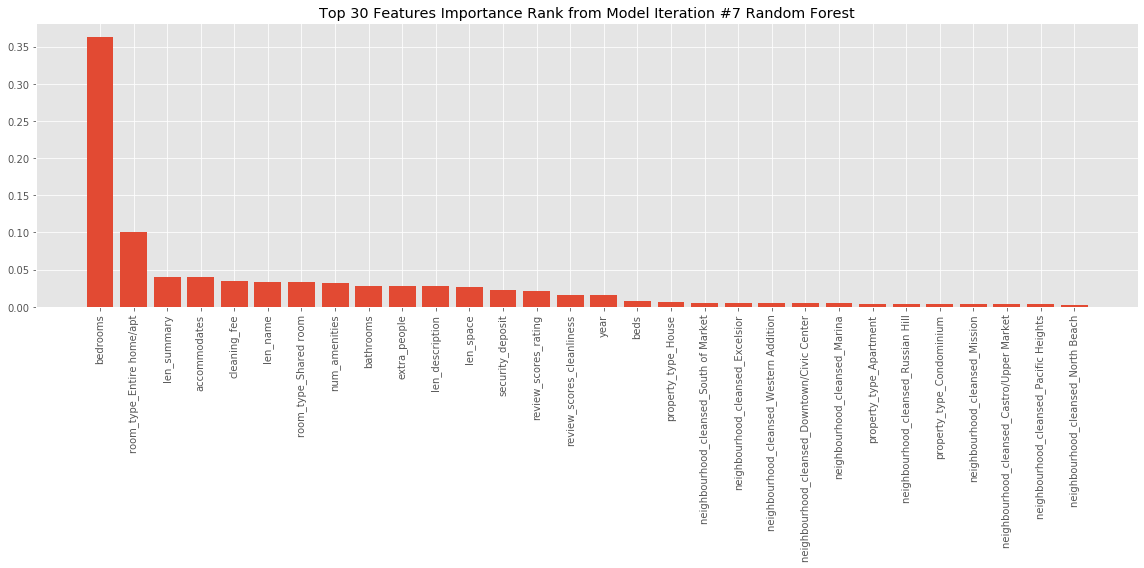

In [66]:
rf_features = X_train.columns
rf_feature_imp = model7.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #7 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
plt.show()

## Model iteration 8: Feature engineer to capture "Entire House/Apartment", "Shared room", "Property-Type:House", & "Property Type: Aprtment" to reduce model complexity

In [67]:
train_df2['House'] = train_df2['property_type'].transform(lambda x: 1 if x=='Apartment' else 0)
train_df2['Apartment'] = train_df2['property_type'].transform(lambda x: 1 if x=='House' else 0)
train_df2['Entire_Space'] = train_df2['room_type'].transform(lambda x: 1 if x=='Entire home/apt' else 0)
train_df2['Shared_room'] = train_df2['room_type'].transform(lambda x: 1 if x=='Shared room' else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [68]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'security_deposit', 'month', 
          'year', 'House', 'Apartment', 'Entire_Space','Shared_room']
X8 = train_df2[features]
y8 = train_df2['price'].apply(np.log)

X8 = pd.get_dummies(X8, columns=['bed_type','neighbourhood_cleansed','month'])

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X8, y8, test_size=0.3, random_state=0)

In [70]:
estimator = RandomForestRegressor()
model8 = estimator.fit(X_train,y_train)
train_preds = model8.predict(X_train)
train_r2 = model8.score(X_train, y_train)
train_rmse = np.sqrt(mean_squared_error(train_preds, y_train))

val_preds = model8.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(val_preds, y_val))
val_r2 = model8.score(X_val, y_val)

cs_val2 = cross_val_score(estimator, X8, y8, cv=3)

train_rmses.append(train_rmse)
train_r2s.append(train_r2)
crossval_r2.append(cs_val2)
val_rmses.append(val_rmse)
val_r2s.append(val_r2)
print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Val R2: 0.9316422285753454, Val RMSE: 1.1977095392122028,
 Validation Cross Val Score: 0.9279162260525914


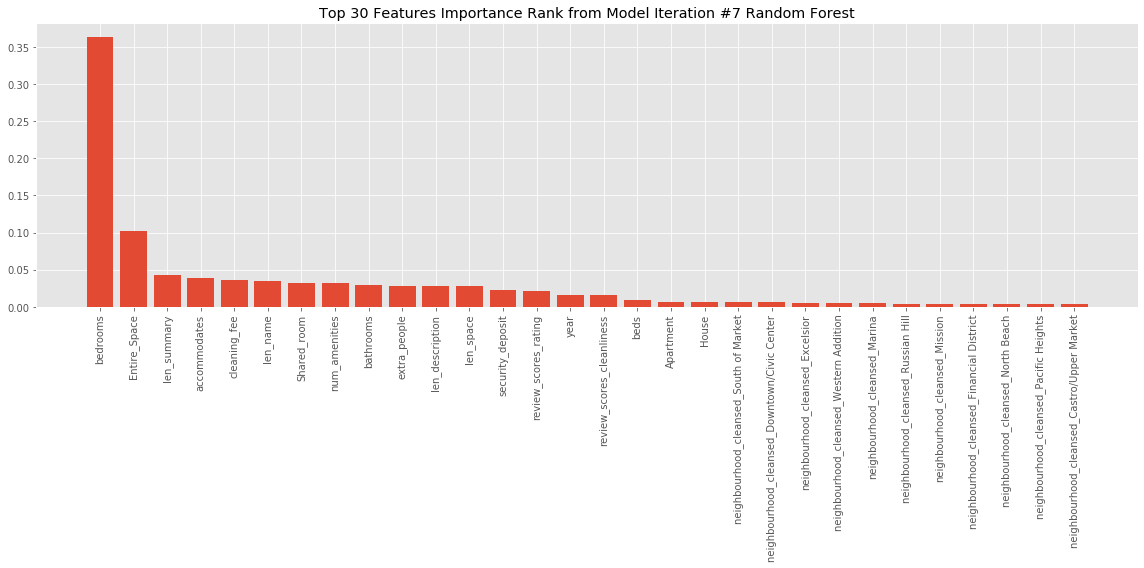

In [71]:
rf_features = X_train.columns
rf_feature_imp = model8.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #7 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
plt.show()

In [72]:
X_train.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'extra_people', 'num_amenities', 'review_scores_cleanliness',
       'len_space', 'len_summary', 'len_description', 'len_name',
       'review_scores_rating', 'security_deposit', 'year', 'House',
       'Apartment', 'Entire_Space', 'Shared_room', 'bed_type_Airbed',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'neighbourhood_cleansed_Bayview',
       'neighbourhood_cleansed_Bernal Heights',
       'neighbourhood_cleansed_Castro/Upper Market',
       'neighbourhood_cleansed_Chinatown',
       'neighbourhood_cleansed_Crocker Amazon',
       'neighbourhood_cleansed_Diamond Heights',
       'neighbourhood_cleansed_Downtown/Civic Center',
       'neighbourhood_cleansed_Excelsior',
       'neighbourhood_cleansed_Financial District',
       'neighbourhood_cleansed_Glen Park',
       'neighbourhood_cleansed_Golden Gate Park',
       'neighbourhood_cleansed_Haight As

**According to GridSearchCV, best hyperparameters are n_estimators=400 & max_features = 20**

In [73]:
estimator = RandomForestRegressor(max_features=20, n_estimators=400)
model10 = estimator.fit(X_train,y_train)
preds = model10.predict(X_val)
r2 = model10.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
print(r2,np.exp(rmse))

0.9439687493098373 1.1774332793114521


In [87]:
cs_val2 = cross_val_score(estimator, X8, y8, cv=3)

In [89]:
np.mean(cs_val2)

0.9415046605092231

In [74]:
#Considered removing neighborhoods all together to reduce complexity, but lower score. 
#Disregard.
# features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
#           'extra_people', 'num_amenities',
#           'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
#           'len_name', 'review_scores_rating', 'security_deposit', 'month', 
#           'year', 'House', 'Apartment', 'Entire_Space','Shared_room']
# X9 = train_df2[features]
# y9 = train_df2['price'].apply(np.log)
# X9 = pd.get_dummies(X9, columns=['bed_type','month'])
# X_train9, X_val9, y_train9, y_val9 = train_test_split(X9, y9, test_size=0.3)

In [75]:
# estimator = RandomForestRegressor()
# model9 = estimator.fit(X_train9,y_train9)
# train_preds = model9.predict(X_train9)
# train_r2 = model9.score(X_train9, y_train9)
# train_rmse = np.sqrt(mean_squared_error(train_preds, y_train9))

# val_preds = model9.predict(X_val)
# val_rmse = np.sqrt(mean_squared_error(val_preds, y_val9))
# val_r2 = model9.score(X_val9, y_val9)

# cs_val2 = cross_val_score(estimator, X9, y9, cv=3)

# train_rmses.append(train_rmse)
# train_r2s.append(train_r2)
# crossval_r2.append(cs_val2)
# val_rmses.append(val_rmse)
# val_r2s.append(val_r2)
# print(f'Val R2: {val_r2}, Val RMSE: {np.exp(val_rmse)},\n Validation Cross Val Score: {np.mean(cs_val2)}')

In [76]:
# rf_features = X_train.columns
# rf_feature_imp = model9.feature_importances_
# feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
#                        columns=['weight']).sort_values('weight',ascending=False)[:30]
# plt.figure(figsize=(16,8))
# plt.bar(x=feat_df.index, height=feat_df['weight'])
# plt.xticks(rotation=90)
# plt.title('Top 30 Features Importance Rank from Model Iteration #7 Random Forest')
# plt.tight_layout()
# # plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
# plt.show()

## Comparing Model Iterations

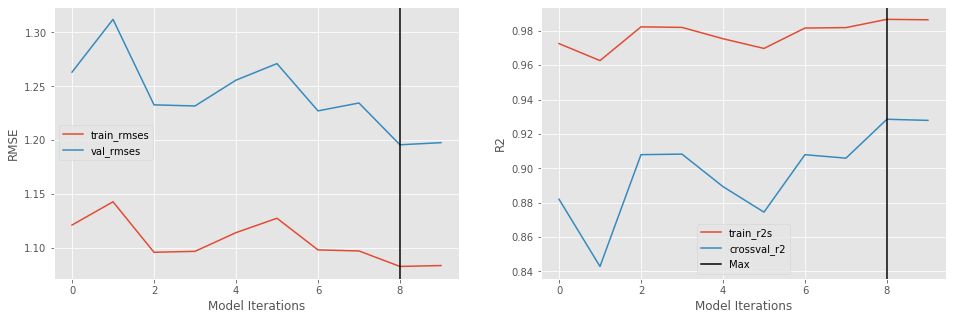

In [77]:
x = np.arange(len(train_r2s))
metric_names=['train_rmses', 'val_rmses', 'train_r2s', 'crossval_r2', 'val_r2s']
metric_lst=[np.exp(train_rmses), np.exp(val_rmses), train_r2s, np.mean(crossval_r2, axis=1), val_r2s]

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(x, metric_lst[0], label=f'{metric_names[0]}')
ax[0].plot(x, metric_lst[1], label=f'{metric_names[1]}')
ax[0].set_xlabel('Model Iterations')
ax[0].set_ylabel('RMSE')
ax[0].legend()
ax[0].axvline(8,color='black', label='Min')
ax[1].plot(x, metric_lst[2], label=f'{metric_names[2]}')
ax[1].plot(x, metric_lst[3], label=f'{metric_names[3]}')
ax[1].axvline(8,color='black', label='Max')
# ax[1].plot(x, metric_lst[4], label=f'{metric_names[4]}')
ax[1].set_xlabel('Model Iterations')
ax[1].set_ylabel('R2')
ax[1].legend()
# plt.savefig('Graphs/Metrics_over_iterations.png',dpi=300)

In [78]:
len(X_train)*.01

1928.05

## Grid Search CV Iteration 9

In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [80]:
np.arange(3,36,9)

array([ 3, 12, 21, 30])

In [81]:
# estimator = RandomForestRegressor()
# param_grid = {'n_estimators' : np.arange(100,500,100),
#               'max_features' : np.arange(3,len(X_train.columns),9),
#              'max_depth': np.linspace(100,len(X_train),5)}
# grid_search = GridSearchCV(estimator, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [82]:
# estimator = RandomForestRegressor(max_features= 80, 
#                                   n_estimators= 400)
# model7 = estimator.fit(X_train,y_train)
# preds = model7.predict(X_val)
# r2 = model7.score(X_val, y_val)
# rmse = np.sqrt(mean_squared_error(preds, y_val))
# cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
# cs_val2 = cross_val_score(estimator, X7, y7, cv=3)
# print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

## Performance on Test Data

In [83]:
#Use on Test Data
#Adding in all feature engineering for best performing model with Random Forest
test['amenities'] = test['amenities'].fillna('0')
test['num_amenities'] = test['amenities'].transform(lambda x: len(x.split(',')))
test[['space','summary','description','name']] = test[['space','summary','description','name']].fillna('0')
test['len_space'] = test['space'].transform(lambda x: 0 if x=='0' else len(x))
test['len_summary'] = test['summary'].transform(lambda x: 0 if x=='0' else len(x))
test['len_description'] = test['description'].transform(lambda x: '0' if x==0 else len(x))
test['len_name'] = test['name'].transform(lambda x: 0 if x=='0' else len(x))
test['House'] = test['property_type'].transform(lambda x: 1 if x=='Apartment' else 0)
test['Apartment'] = test['property_type'].transform(lambda x: 1 if x=='House' else 0)
test['Entire_Space'] = test['room_type'].transform(lambda x: 1 if x=='Entire home/apt' else 0)
test['Shared_room'] = test['room_type'].transform(lambda x: 1 if x=='Shared room' else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on 

In [84]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'security_deposit', 'month', 
          'year', 'House', 'Apartment', 'Entire_Space','Shared_room']
X_test = test[features]
y_test = test['price'].apply(np.log)

X_test = pd.get_dummies(X_test, columns=['bed_type','neighbourhood_cleansed','month'])

In [85]:
preds = model8.predict(X_test)
r2 = model8.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
print(r2,np.exp(rmse))

0.9315299399564629 1.1979913414316623


In [86]:
preds = model10.predict(X_test)
r2 = model10.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(preds, y_test))
print(r2,np.exp(rmse))

0.9446734791150697 1.1763127797478952
